# 3D AugmentedReality Course Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

import binvox_rw
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import h5py
from PIL import Image

#external libraries written by me for this notebook
from extraction_performances import extraction_performances
from IAHOS import IAHOS
from hyperparams_initialization import hyperparams_initialization
from plots import plot_dataset_situation,plot_IAHOS,plot_model,plot_confusion_matrix
from plots import plot_training_accuracy,plot_validation_accuracy,plot_test_scores,plot_output_NN
from dataset_situation import dataset_situation,creation_datasets

#libraries of Keras for the neural networks
import keras
from keras import backend as K
from keras_radam import RAdam
from keras.models import Sequential,Input,Model
from keras.layers import *
from keras.layers import Conv3D,Conv2D,MaxPooling3D,MaxPooling2D,Dense
from keras.layers import Flatten,Dropout,Reshape,UpSampling3D
from keras import initializers,optimizers,backend as k
from keras.callbacks import EarlyStopping,ModelCheckpoint
from time import time

Using TensorFlow backend.


In [2]:
dtype='float16'
K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
K.set_epsilon(1e-4)

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [ ]:
classes,lengths,screens,maximum=dataset_situation()
plot_dataset_situation(classes,lengths,screens)

In [4]:
#parameters for the classification part
maximum = 56 #max number of models per class due to the lack of homogeneity on the dataset
dataset_classification=True#if you want to construct and save the dataset
#for the first part of the project: the classification
reduction=True#let
noise=False
ratio_voxels = 4 #how many times you want to reduce the dimension of the 128x128x128 voxels: 
#with ratio_voxels=2 you will have 64x64x64 volumes; bigger ratio, smaller volumes. Let
#reduction=True as default for the classification task: if reduction=False the
#final dataset will be too heavy
from3dto2d=False
#paramters for the autoencoder (from 2D images to 3D models)
ratio_images = 8 #how many times you want to reduce the dimension of the
#512x512 images used for the autoencoder part of the project
dataset_autoencoder=False#if you want to process and save the dataset for the 
#third part of the project: the autoencoder

creation_datasets(maximum,ratio_voxels,ratio_images,reduction,dataset_classification,dataset_autoencoder,noise,from3dto2d)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [09:49<00:00, 10.71s/it]


Part A of the Project - Classification of 3D models

In [ ]:
classes = np.load('classes.npy')
labels = np.load('labels1.npy')
hf = h5py.File('data32.h5', 'r')
n1 = hf.get('dataset_1')
n1 = np.array(n1)
hf.close()
dim=32
randomize = np.arange(len(n1))
np.random.shuffle(randomize)
n1=n1[randomize]
index1 = int(len(n1)*0.7)
index2 = int(len(n1)*0.1)
training_set = n1[0:index1].reshape((-1,dim,dim,dim,1))
validation_set = n1[index1:index1+index2].reshape((-1,dim,dim,dim,1))
test_set = n1[index1+index2:].reshape((-1,dim,dim,dim,1))
training_labels=labels[0:index1]
validation_labels=labels[index1:index1+index2]
test_labels=labels[index1+index2:]
del n1,hf#save RAM

In [5]:
#Load dataset from disk
classes = np.load('classes.npy')
labels = np.load('labels.npy')
dim=32
#hf = h5py.File('dataset.h5', 'r')
#n1 = hf.get('dataset_1')
#n1 = np.array(n1)
#hf.close()
#randomize = np.arange(len(n1))
#np.random.shuffle(randomize)
#n1=n1[randomize]
data=np.load('dataset.npy')
randomize=np.arange(len(data))
np.random.shuffle(randomize)
data=data[randomize]
labels=labels[randomize]
data=data.reshape((-1,dim,dim,dim,1))
#index1 = int(len(n1)*0.7)
#index2 = int(len(n1)*0.1)
#training_set = n1[0:index1].reshape((-1,dim,dim,dim,1))
index1 = int(len(data)*0.7)
index2 = int(len(data)*0.1)
training_set = data[0:index1].reshape((-1,dim,dim,dim,1))
training_labels=labels[0:index1]
#validation_set = n1[index1:index1+index2].reshape((-1,dim,dim,dim,1))
validation_set = data[index1:index1+index2].reshape((-1,dim,dim,dim,1))
validation_labels=labels[index1:index1+index2]
#test_set = n1[index1+index2:].reshape((-1,dim,dim,dim,1))
test_set = data[index1+index2:].reshape((-1,dim,dim,dim,1))
test_labels=labels[index1+index2:]
#del n1,hf#save RAM

In [6]:
def Classifier(input_size,i,hm,optimizer,mode):
    x = Input(shape=(input_size,input_size,input_size,1))
    x1 = (Conv3D(int(hm[0,i]),kernel_size=(int(hm[1,i]),int(hm[1,i]),int(hm[1,i])),activation='relu'))(x)
    x1 = (MaxPooling3D(pool_size=(int(hm[2,i]),int(hm[2,i]),int(hm[2,i])),
                       strides=(int(hm[3,i]),int(hm[3,i]),int(hm[3,i]))))(x1)
    for j in range(int(hm[4,i])):
        x1 = (Conv3D(int(hm[5,i]),kernel_size=(int(hm[6,i]),int(hm[6,i]),int(hm[6,i])),activation='relu'))(x1)
    y1 = Flatten()(x1)
    y2 = (Dense(int(hm[7,i]),activation='relu'))(y1)
    if mode=='test':
        y2 = Dropout(0)(y2)
    else:
        y2 = Dropout(hm[8,i])(y2)
    y = (Dense(55,activation='softmax'))(y2)
    classifier=Model(inputs=x,outputs=y)
    if optimizer=='radam':
        Optimizer=RAdam()
    else:
        Optimizer=optimizer
    classifier.compile(optimizer=Optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    return classifier

In [7]:
attempts=2
variables=9
iterations=attempts**variables
limits = [[2,4],[2,4],[2,3],[1,2],[0,3],[2,4],[2,4],[55,200],[0,0.5]]
method='grid'
rounds=2

In [8]:
tgp,tgp2,ogp,ogp2,final=IAHOS(rounds,method,limits,attempts,variables,iterations,Classifier,
                       training_set,training_labels,validation_set,validation_labels,32)
np.save('final',final)

Round  1  of  2


  0%|                                                                                          | 0/512 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


 50%|████████████████████████████████████████                                        | 256/512 [12:30<10:47,  2.53s/it]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [24:03<00:00,  2.82s/it]


Round  2  of  2


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [27:34<00:00,  3.23s/it]


In [16]:
#hyperparameters studied for this neural network
y = ['#filter1','kernel1','maxpool1','stride_pool','#layers',
         '#filter2','kernel2','fully_dim','dropout']
plot_IAHOS(y,ogp,ogp2,tgp,tgp2)

In [10]:
dim=32
final = np.load('final.npy')
best_hp = np.zeros((variables,1))
for i in range(variables):
    best_hp[i]=final[i]

In [11]:
l=0
epochs=100
training_accuracy=[]
validation_accuracy=[]
test_scores=[]
optimizers = ['radam','sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']
classifier=Classifier(dim,0,best_hp,optimizers[0],'test')
print (classifier.summary())

j=0
for optimizer in tqdm(optimizers):   
    mc = ModelCheckpoint('best_model_'+str(optimizer)+'.h5', monitor='val_acc', mode='max',
                     verbose=0,save_best_only=True)
    classifier=Classifier(dim,0,best_hp,optimizer,'test')
    history=classifier.fit(training_set,training_labels,validation_data=(validation_set,validation_labels),
                           epochs=epochs,batch_size=64,verbose=2,callbacks=[mc],shuffle=True)
    
    training_accuracy.append(history.history['acc'])
    validation_accuracy.append(history.history['val_acc'])
    j+=1
    if j<7:
        del classifier,history,mc
        K.clear_session()
    l+=1
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 32, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 3)     84        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 29, 29, 29, 3)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73167)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 151)               11048368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 151)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 55)                8360      
Total para

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 3.0279 - acc: 0.3098 - val_loss: 2.4527 - val_acc: 0.4707
Epoch 2/100
 - 2s - loss: 1.6988 - acc: 0.6141 - val_loss: 2.3415 - val_acc: 0.4935
Epoch 3/100
 - 2s - loss: 1.1386 - acc: 0.7319 - val_loss: 2.2134 - val_acc: 0.5130
Epoch 4/100
 - 2s - loss: 0.8762 - acc: 0.7904 - val_loss: 2.3898 - val_acc: 0.5357
Epoch 5/100
 - 2s - loss: 0.6456 - acc: 0.8511 - val_loss: 2.3700 - val_acc: 0.5487
Epoch 6/100
 - 2s - loss: 0.5205 - acc: 0.8873 - val_loss: 2.3695 - val_acc: 0.5585
Epoch 7/100
 - 2s - loss: 0.4502 - acc: 0.8961 - val_loss: 2.5148 - val_acc: 0.5357
Epoch 8/100
 - 2s - loss: 0.3884 - acc: 0.9082 - val_loss: 2.5299 - val_acc: 0.5389
Epoch 9/100
 - 2s - loss: 0.3169 - acc: 0.9360 - val_loss: 2.5044 - val_acc: 0.5519
Epoch 10/100
 - 2s - loss: 0.3010 - acc: 0.9392 - val_loss: 2.5646 - val_acc: 0.5519
Epoch 11/100
 - 2s - loss: 0.2585 - acc: 0.9499 - val_loss: 2.5873 - val_acc: 0.5455
Epoch 12/100
 - 2s - loss: 

Epoch 97/100
 - 2s - loss: 0.0775 - acc: 0.9833 - val_loss: 2.9235 - val_acc: 0.5552
Epoch 98/100
 - 2s - loss: 0.0773 - acc: 0.9819 - val_loss: 2.9240 - val_acc: 0.5520
Epoch 99/100
 - 2s - loss: 0.0781 - acc: 0.9819 - val_loss: 2.9382 - val_acc: 0.5584
Epoch 100/100
 - 2s - loss: 0.0775 - acc: 0.9847 - val_loss: 2.9236 - val_acc: 0.5649


 12%|██████████▍                                                                        | 1/8 [02:35<18:10, 155.73s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 3.8901 - acc: 0.0951 - val_loss: 3.7009 - val_acc: 0.1656
Epoch 2/100
 - 1s - loss: 3.2932 - acc: 0.2876 - val_loss: 2.9772 - val_acc: 0.3279
Epoch 3/100
 - 1s - loss: 2.4596 - acc: 0.4722 - val_loss: 2.4616 - val_acc: 0.4350
Epoch 4/100
 - 1s - loss: 1.9074 - acc: 0.5668 - val_loss: 2.2198 - val_acc: 0.4838
Epoch 5/100
 - 1s - loss: 1.6245 - acc: 0.6160 - val_loss: 2.2902 - val_acc: 0.4838
Epoch 6/100
 - 1s - loss: 1.4151 - acc: 0.6512 - val_loss: 2.3519 - val_acc: 0.4448
Epoch 7/100
 - 1s - loss: 1.2446 - acc: 0.6906 - val_loss: 2.8227 - val_acc: 0.3734
Epoch 8/100
 - 2s - loss: 1.2402 - acc: 0.7018 - val_loss: 2.0763 - val_acc: 0.5324
Epoch 9/100
 - 1s - loss: 0.9680 - acc: 0.7519 - val_loss: 2.2472 - val_acc: 0.5195
Epoch 10/100
 - 1s - loss: 0.8387 - acc: 0.7852 - val_loss: 2.2486 - val_acc: 0.4967
Epoch 11/100
 - 1s - loss: 0.7877 - acc: 0.7927 - val_loss: 2.2143 - val_acc: 0.5065
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0995 - acc: 0.9745 - val_loss: 2.6480 - val_acc: 0.5585
Epoch 98/100
 - 1s - loss: 0.1062 - acc: 0.9703 - val_loss: 2.6694 - val_acc: 0.5682
Epoch 99/100
 - 1s - loss: 0.0902 - acc: 0.9787 - val_loss: 2.7307 - val_acc: 0.5552
Epoch 100/100
 - 1s - loss: 0.0995 - acc: 0.9754 - val_loss: 2.6269 - val_acc: 0.5747


 25%|████████████████████▊                                                              | 2/8 [04:56<15:08, 151.39s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 2.7085 - acc: 0.4017 - val_loss: 2.0539 - val_acc: 0.5162
Epoch 2/100
 - 1s - loss: 1.1761 - acc: 0.7078 - val_loss: 1.8658 - val_acc: 0.5519
Epoch 3/100
 - 1s - loss: 0.6766 - acc: 0.8228 - val_loss: 1.9781 - val_acc: 0.5324
Epoch 4/100
 - 1s - loss: 0.4135 - acc: 0.8984 - val_loss: 2.0046 - val_acc: 0.5259
Epoch 5/100
 - 1s - loss: 0.3000 - acc: 0.9295 - val_loss: 2.0411 - val_acc: 0.5552
Epoch 6/100
 - 1s - loss: 0.2122 - acc: 0.9397 - val_loss: 2.2190 - val_acc: 0.5454
Epoch 7/100
 - 1s - loss: 0.1971 - acc: 0.9499 - val_loss: 2.1772 - val_acc: 0.5747
Epoch 8/100
 - 1s - loss: 0.1690 - acc: 0.9564 - val_loss: 2.2432 - val_acc: 0.5454
Epoch 9/100
 - 1s - loss: 0.1350 - acc: 0.9634 - val_loss: 2.2720 - val_acc: 0.5455
Epoch 10/100
 - 1s - loss: 0.1152 - acc: 0.9685 - val_loss: 2.2853 - val_acc: 0.5811
Epoch 11/100
 - 1s - loss: 0.1104 - acc: 0.9703 - val_loss: 2.1895 - val_acc: 0.5422
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0396 - acc: 0.9856 - val_loss: 2.9005 - val_acc: 0.5227
Epoch 98/100
 - 1s - loss: 0.0399 - acc: 0.9870 - val_loss: 2.8449 - val_acc: 0.5227
Epoch 99/100
 - 1s - loss: 0.0404 - acc: 0.9856 - val_loss: 2.8585 - val_acc: 0.5260
Epoch 100/100
 - 1s - loss: 0.0395 - acc: 0.9870 - val_loss: 2.8237 - val_acc: 0.5260


 38%|███████████████████████████████▏                                                   | 3/8 [07:22<12:28, 149.70s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 3.1686 - acc: 0.3813 - val_loss: 2.1670 - val_acc: 0.5097
Epoch 2/100
 - 1s - loss: 1.0699 - acc: 0.7277 - val_loss: 1.9308 - val_acc: 0.5454
Epoch 3/100
 - 1s - loss: 0.5052 - acc: 0.8738 - val_loss: 2.0167 - val_acc: 0.5324
Epoch 4/100
 - 1s - loss: 0.3059 - acc: 0.9253 - val_loss: 1.9714 - val_acc: 0.5455
Epoch 5/100
 - 1s - loss: 0.2328 - acc: 0.9457 - val_loss: 2.0533 - val_acc: 0.5714
Epoch 6/100
 - 1s - loss: 0.1805 - acc: 0.9629 - val_loss: 2.0989 - val_acc: 0.5714
Epoch 7/100
 - 1s - loss: 0.1571 - acc: 0.9652 - val_loss: 2.1833 - val_acc: 0.5682
Epoch 8/100
 - 1s - loss: 0.1423 - acc: 0.9666 - val_loss: 2.2307 - val_acc: 0.5617
Epoch 9/100
 - 1s - loss: 0.1282 - acc: 0.9675 - val_loss: 2.1981 - val_acc: 0.5617
Epoch 10/100
 - 1s - loss: 0.1238 - acc: 0.9740 - val_loss: 2.2723 - val_acc: 0.5747
Epoch 11/100
 - 1s - loss: 0.1156 - acc: 0.9768 - val_loss: 2.2656 - val_acc: 0.5747
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0678 - acc: 0.9819 - val_loss: 2.4471 - val_acc: 0.5649
Epoch 98/100
 - 1s - loss: 0.0689 - acc: 0.9838 - val_loss: 2.4432 - val_acc: 0.5617
Epoch 99/100
 - 1s - loss: 0.0678 - acc: 0.9824 - val_loss: 2.4464 - val_acc: 0.5617
Epoch 100/100
 - 1s - loss: 0.0658 - acc: 0.9856 - val_loss: 2.4813 - val_acc: 0.5714


 50%|█████████████████████████████████████████▌                                         | 4/8 [09:47<09:53, 148.26s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 3.2536 - acc: 0.2449 - val_loss: 2.5699 - val_acc: 0.4058
Epoch 2/100
 - 2s - loss: 1.7996 - acc: 0.5580 - val_loss: 2.1334 - val_acc: 0.5097
Epoch 3/100
 - 2s - loss: 1.0985 - acc: 0.7059 - val_loss: 2.0479 - val_acc: 0.5422
Epoch 4/100
 - 2s - loss: 0.7188 - acc: 0.7927 - val_loss: 2.3569 - val_acc: 0.5097
Epoch 5/100
 - 2s - loss: 0.4826 - acc: 0.8692 - val_loss: 2.2995 - val_acc: 0.5293
Epoch 6/100
 - 2s - loss: 0.3793 - acc: 0.8891 - val_loss: 2.5292 - val_acc: 0.5130
Epoch 7/100
 - 2s - loss: 0.2900 - acc: 0.9156 - val_loss: 2.5973 - val_acc: 0.5617
Epoch 8/100
 - 2s - loss: 0.2460 - acc: 0.9327 - val_loss: 2.4761 - val_acc: 0.5455
Epoch 9/100
 - 2s - loss: 0.2046 - acc: 0.9416 - val_loss: 2.5633 - val_acc: 0.5520
Epoch 10/100
 - 2s - loss: 0.1722 - acc: 0.9508 - val_loss: 2.5953 - val_acc: 0.5844
Epoch 11/100
 - 2s - loss: 0.1621 - acc: 0.9555 - val_loss: 2.6254 - val_acc: 0.5617
Epoch 12/100
 - 2s - loss: 

Epoch 97/100
 - 2s - loss: 0.0494 - acc: 0.9861 - val_loss: 3.1760 - val_acc: 0.5519
Epoch 98/100
 - 2s - loss: 0.0479 - acc: 0.9865 - val_loss: 3.1842 - val_acc: 0.5584
Epoch 99/100
 - 2s - loss: 0.0479 - acc: 0.9870 - val_loss: 3.1785 - val_acc: 0.5552
Epoch 100/100
 - 2s - loss: 0.0485 - acc: 0.9856 - val_loss: 3.1626 - val_acc: 0.5487


 62%|███████████████████████████████████████████████████▉                               | 5/8 [12:23<07:31, 150.48s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 3.7882 - acc: 0.1067 - val_loss: 3.0171 - val_acc: 0.2987
Epoch 2/100
 - 1s - loss: 2.2059 - acc: 0.4828 - val_loss: 2.1410 - val_acc: 0.4837
Epoch 3/100
 - 1s - loss: 1.1737 - acc: 0.7106 - val_loss: 2.1457 - val_acc: 0.4968
Epoch 4/100
 - 1s - loss: 0.7529 - acc: 0.8019 - val_loss: 2.1100 - val_acc: 0.5162
Epoch 5/100
 - 1s - loss: 0.5042 - acc: 0.8771 - val_loss: 2.3025 - val_acc: 0.5422
Epoch 6/100
 - 1s - loss: 0.3726 - acc: 0.9114 - val_loss: 2.2887 - val_acc: 0.5455
Epoch 7/100
 - 1s - loss: 0.3545 - acc: 0.9123 - val_loss: 2.2570 - val_acc: 0.5487
Epoch 8/100
 - 1s - loss: 0.2493 - acc: 0.9425 - val_loss: 2.1831 - val_acc: 0.5390
Epoch 9/100
 - 2s - loss: 0.2595 - acc: 0.9397 - val_loss: 2.2839 - val_acc: 0.5714
Epoch 10/100
 - 1s - loss: 0.2650 - acc: 0.9443 - val_loss: 2.1935 - val_acc: 0.5519
Epoch 11/100
 - 1s - loss: 0.1945 - acc: 0.9620 - val_loss: 2.3661 - val_acc: 0.5325
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0769 - acc: 0.9838 - val_loss: 2.9873 - val_acc: 0.5389
Epoch 98/100
 - 1s - loss: 0.0802 - acc: 0.9838 - val_loss: 3.0044 - val_acc: 0.5389
Epoch 99/100
 - 1s - loss: 0.0790 - acc: 0.9833 - val_loss: 3.0001 - val_acc: 0.5389
Epoch 100/100
 - 1s - loss: 0.0778 - acc: 0.9842 - val_loss: 2.9972 - val_acc: 0.5324


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [14:53<05:00, 150.49s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 2.9433 - acc: 0.3618 - val_loss: 2.3143 - val_acc: 0.4546
Epoch 2/100
 - 1s - loss: 1.4318 - acc: 0.6512 - val_loss: 2.0473 - val_acc: 0.5324
Epoch 3/100
 - 1s - loss: 0.9047 - acc: 0.7718 - val_loss: 2.0176 - val_acc: 0.5422
Epoch 4/100
 - 1s - loss: 0.6065 - acc: 0.8581 - val_loss: 2.0211 - val_acc: 0.5746
Epoch 5/100
 - 1s - loss: 0.4216 - acc: 0.9045 - val_loss: 2.1282 - val_acc: 0.5487
Epoch 6/100
 - 1s - loss: 0.3237 - acc: 0.9318 - val_loss: 2.1371 - val_acc: 0.5552
Epoch 7/100
 - 1s - loss: 0.2721 - acc: 0.9434 - val_loss: 2.1709 - val_acc: 0.5682
Epoch 8/100
 - 1s - loss: 0.2413 - acc: 0.9499 - val_loss: 2.2390 - val_acc: 0.5487
Epoch 9/100
 - 1s - loss: 0.2288 - acc: 0.9513 - val_loss: 2.3901 - val_acc: 0.5227
Epoch 10/100
 - 1s - loss: 0.2180 - acc: 0.9536 - val_loss: 2.4186 - val_acc: 0.5617
Epoch 11/100
 - 1s - loss: 0.2048 - acc: 0.9587 - val_loss: 2.4430 - val_acc: 0.5585
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0843 - acc: 0.9838 - val_loss: 2.6704 - val_acc: 0.5487
Epoch 98/100
 - 1s - loss: 0.0867 - acc: 0.9819 - val_loss: 2.6783 - val_acc: 0.5520
Epoch 99/100
 - 1s - loss: 0.0873 - acc: 0.9796 - val_loss: 2.6865 - val_acc: 0.5552
Epoch 100/100
 - 1s - loss: 0.0877 - acc: 0.9828 - val_loss: 2.6755 - val_acc: 0.5584


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [17:21<02:29, 149.53s/it]

Train on 2156 samples, validate on 308 samples
Epoch 1/100
 - 2s - loss: 6.6353 - acc: 0.1665 - val_loss: 3.5895 - val_acc: 0.2208
Epoch 2/100
 - 2s - loss: 2.3954 - acc: 0.4425 - val_loss: 2.1345 - val_acc: 0.5097
Epoch 3/100
 - 2s - loss: 0.9952 - acc: 0.7509 - val_loss: 1.9755 - val_acc: 0.5422
Epoch 4/100
 - 2s - loss: 0.4457 - acc: 0.8924 - val_loss: 2.1091 - val_acc: 0.5422
Epoch 5/100
 - 2s - loss: 0.2558 - acc: 0.9467 - val_loss: 2.3066 - val_acc: 0.5065
Epoch 6/100
 - 2s - loss: 0.2041 - acc: 0.9564 - val_loss: 2.2952 - val_acc: 0.5259
Epoch 7/100
 - 2s - loss: 0.1588 - acc: 0.9694 - val_loss: 2.4374 - val_acc: 0.5292
Epoch 8/100
 - 2s - loss: 0.1440 - acc: 0.9722 - val_loss: 2.4125 - val_acc: 0.5195
Epoch 9/100
 - 2s - loss: 0.1275 - acc: 0.9782 - val_loss: 2.4625 - val_acc: 0.5292
Epoch 10/100
 - 2s - loss: 0.1234 - acc: 0.9773 - val_loss: 2.4589 - val_acc: 0.5292
Epoch 11/100
 - 2s - loss: 0.1266 - acc: 0.9782 - val_loss: 2.5299 - val_acc: 0.5487
Epoch 12/100
 - 2s - loss: 

Epoch 97/100
 - 2s - loss: 0.0816 - acc: 0.9847 - val_loss: 2.8739 - val_acc: 0.5357
Epoch 98/100
 - 2s - loss: 0.0812 - acc: 0.9819 - val_loss: 2.8884 - val_acc: 0.5324
Epoch 99/100
 - 2s - loss: 0.0811 - acc: 0.9847 - val_loss: 2.8970 - val_acc: 0.5357
Epoch 100/100
 - 2s - loss: 0.0818 - acc: 0.9819 - val_loss: 2.8918 - val_acc: 0.5325


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [19:57<00:00, 149.70s/it]


In [12]:
optimizers = ['radam','sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']
test_scores=[]
j=0
for optimizer in optimizers:
    classifier=Classifier(32,0,best_hp,optimizer,'test')
    classifier.load_weights('best_model_'+str(optimizer)+'.h5')
    predictions = classifier.predict(test_set)
    new_test_labels = np.zeros(test_labels.shape[0])
    for i in range(test_labels.shape[0]):
        new_test_labels[i]=np.argmax(test_labels[i])
    y_pred = np.zeros(test_labels.shape[0])
    for i in range(test_labels.shape[0]):
        y_pred[i]=np.argmax(predictions[i])
    score=accuracy_score(y_true=new_test_labels,y_pred=y_pred, normalize=True)
    test_scores.append(score)
    j+=1
    del classifier
y = np.zeros((8,1))
for i in range(8):
    y[i,0]=test_scores[i]

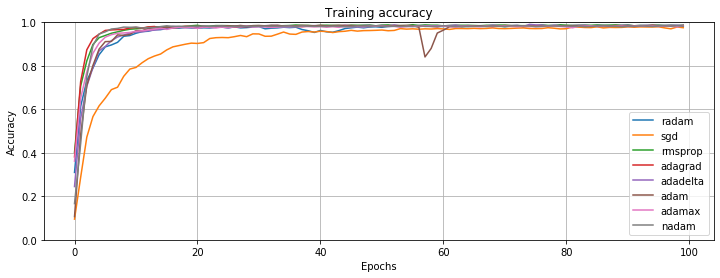

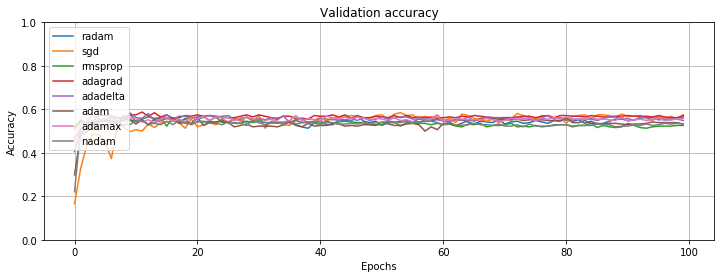

In [13]:
model='CNN1'
scores=['test score accuracy']
plot_training_accuracy(training_accuracy,optimizers,model)
plot_validation_accuracy(validation_accuracy,optimizers,model)
plot_test_scores(scores,y,model)

Confusion matrix

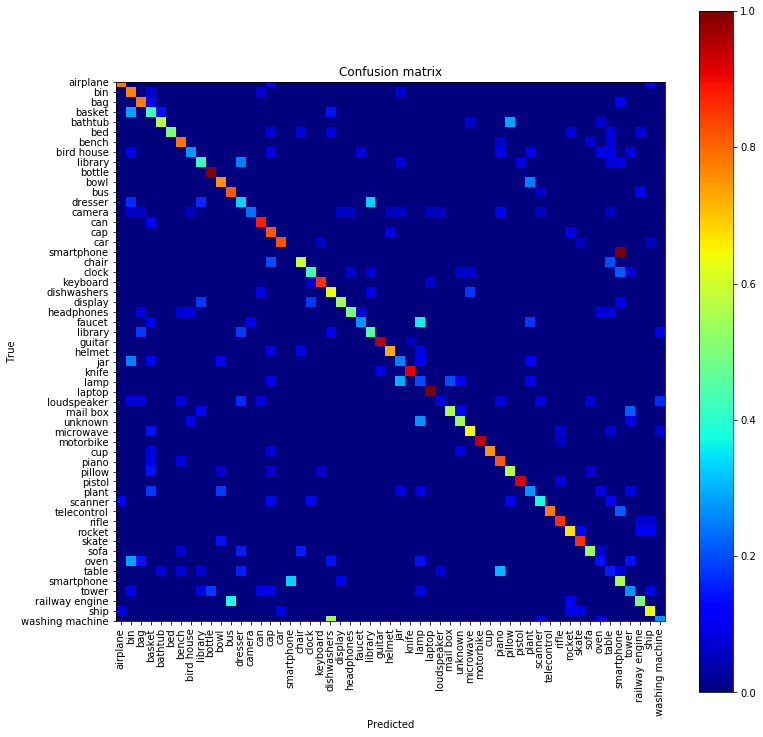

                 precision    recall  f1-score   support

       airplane       0.78      0.78      0.78         9
            bin       0.48      0.77      0.59        13
            bag       0.54      0.78      0.64         9
         basket       0.19      0.43      0.26         7
        bathtub       0.80      0.57      0.67        14
            bed       1.00      0.50      0.67        12
          bench       0.69      0.79      0.73        14
     bird house       0.50      0.27      0.35        11
        library       0.45      0.42      0.43        12
         bottle       0.78      1.00      0.88         7
           bowl       0.55      0.75      0.63         8
            bus       0.81      0.81      0.81        16
        dresser       0.15      0.33      0.21         6
         camera       0.80      0.24      0.36        17
            can       0.64      0.88      0.74         8
            cap       0.47      0.82      0.60        11
            car       0.93    

In [14]:
classifier=Classifier(32,0,best_hp,optimizer,'test')
classifier.load_weights('best_model_sgd.h5')
predictions = classifier.predict(test_set)
new_test_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])
plot_confusion_matrix(new_test_labels,y_pred,classes,'CNN1')
print(classification_report(new_test_labels, y_pred, target_names=classes))

In [ ]:
#here a random sample from test set is chosen and feeded to the NN, plotted its 3D model 
#and the resulting probability distribution

True class:  library
Predicted clas:  library


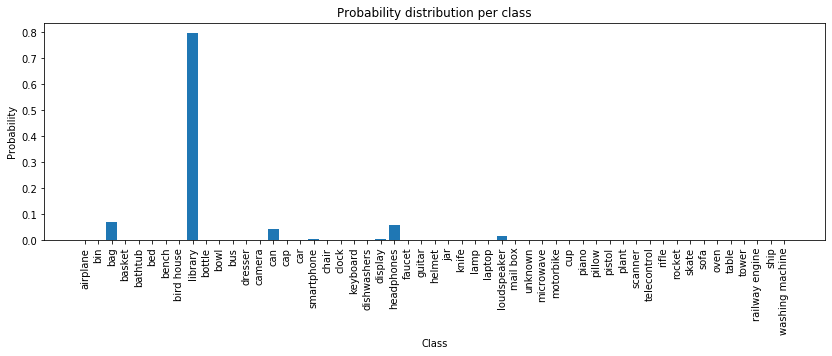

In [15]:
sample = np.random.randint(data.shape[0])
plot_model(np.asarray(data[sample][:,:,:,0]))
print ("True class: ",classes[np.argmax(labels[sample])])
print ("Predicted clas: ",classes[np.argmax(classifier.predict(data[sample].reshape(-1,32,32,32,1)))])
plot_output_NN(classes,classifier,data[sample].reshape(-1,32,32,32,1))

Part B of the Project - Convolutions in 2D

In [17]:
data = np.load('2dimages.npy')
print (data.shape)
training_labels=np.zeros((int(len(data)*0.7/3),55))
validation_labels=np.zeros((int(len(data)*0.15/3),55))
test_labels=np.zeros((int(len(data)*0.15/3),55))
training_set = np.zeros((int(len(data)*0.7/3),3,128,128))
validation_set = np.zeros((int(len(data)*0.15/3),3,128,128))
test_set = np.zeros((int(len(data)*0.15/3),3,128,128))
counter1=0
counter2=0
counter3=0
for i in range(len(data)):
    split=i%60
    j=int(i/60)
    if split<42 and i%3==0:
        training_set[counter1,0,:,:]=data[i]
        training_set[counter1,1,:,:]=data[i+1]
        training_set[counter1,2,:,:]=data[i+2]
        training_labels[counter1,j]=1
        counter1+=1
    elif split>41 and split<51 and i%3==0:
        validation_set[counter2,0,:,:]=data[i]
        validation_set[counter2,1,:,:]=data[i+1]
        validation_set[counter2,2,:,:]=data[i+2]
        validation_labels[counter2,j]=1
        counter2+=1
    elif split>50 and i%3==0:
        test_set[counter3,0,:,:]=data[i]
        test_set[counter3,1,:,:]=data[i+1]
        test_set[counter3,2,:,:]=data[i+2]
        test_labels[counter3,j]=1
        counter3+=1
print (training_set.shape)
#training_set=training_set.reshape((-1,3,128,128))        
#validation_set=validation_set.reshape((-1,3,128,128))
#test_set=test_set.reshape((-1,3,128,128))
print (training_labels.shape)

(3300, 128, 128)
(770, 3, 128, 128)
(770, 55)


In [19]:
def Classifier(input_size,i,hm,optimizer,mode):
    x = Input(shape=(3,input_size,input_size))
    x1 = (Conv2D(int(hm[0,i]),kernel_size=(int(hm[1,i]),int(hm[1,i])),activation='relu',data_format='channels_first'))(x)
    x1 = (MaxPooling2D(pool_size=(int(hm[2,i]),int(hm[2,i])),
                       strides=(int(hm[3,i]),int(hm[3,i])),data_format='channels_first'))(x1)
    for j in range(int(hm[4,i])):
        x1 = (Conv2D(int(hm[5,i]),kernel_size=(int(hm[6,i]),int(hm[6,i])),activation='relu',data_format='channels_first'))(x1)
    y1 = Flatten()(x1)
    y2 = (Dense(int(hm[7,i]),activation='relu'))(y1)
    if mode=='test':
        y2 = Dropout(0)(y2)
    else:
        y2 = Dropout(hm[8,i])(y2)
    y = (Dense(55,activation='softmax'))(y2)
    classifier=Model(inputs=x,outputs=y)
    if optimizer=='radam':
        Optimizer=RAdam()
    else:
        Optimizer=optimizer
    classifier.compile(optimizer=Optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    return classifier

In [20]:
attempts=2
variables=9
iterations=attempts**variables
limits = [[8,16],[1,3],[1,3],[1,2],[0,2],[8,16],[2,4],[55,200],[0,0.5]]
method='grid'
rounds=2

In [21]:
tgp,tgp2,ogp,ogp2,final=IAHOS(rounds,method,limits,attempts,variables,iterations,Classifier,
                       training_set,training_labels,validation_set,validation_labels,128)
np.save('final_CNN_2D',final)

Round  1  of  2


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [17:58<00:00,  2.11s/it]


Round  2  of  2


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [17:30<00:00,  2.05s/it]


In [23]:
#hyperparameters studied for this neural network
y = ['#filter1','kernel1','maxpool1','stride_pool','#layers',
         '#filter2','kernel2','fully_dim','dropout']
plot_IAHOS(y,ogp,ogp2,tgp,tgp2)

In [24]:
dim=128
final = np.load('final_CNN_2D.npy')
best_hp = np.zeros((variables,1))
for i in range(variables):
    best_hp[i]=final[i]

In [25]:
l=0
epochs=100
training_accuracy=[]
validation_accuracy=[]
test_scores=[]
optimizers = ['radam','sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']
classifier=Classifier(dim,0,best_hp,optimizers[0],'test')
print (classifier.summary())

j=0
for optimizer in tqdm(optimizers):   
    mc = ModelCheckpoint('best_model_CNN_2D'+str(optimizer)+'.h5', monitor='val_acc', mode='max',
                     verbose=0,save_best_only=True)
    classifier=Classifier(dim,0,best_hp,optimizer,'test')
    history=classifier.fit(training_set,training_labels,validation_data=(validation_set,validation_labels),
                           epochs=epochs,batch_size=4,verbose=2,callbacks=[mc])
    
    training_accuracy.append(history.history['acc'])
    validation_accuracy.append(history.history['val_acc'])
    j+=1
    if j<7:
        del classifier,history,mc
        K.clear_session()
    l+=1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 128, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 128, 128)      52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 128, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 212992)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 151)               32161943  
_________________________________________________________________
dropout_1 (Dropout)          (None, 151)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 55)                8360      
Total para

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 7s - loss: 3.8065 - acc: 0.1455 - val_loss: 3.2032 - val_acc: 0.1939
Epoch 2/100
 - 6s - loss: 3.0736 - acc: 0.2351 - val_loss: 3.1265 - val_acc: 0.2303
Epoch 3/100
 - 6s - loss: 2.7828 - acc: 0.3078 - val_loss: 2.9352 - val_acc: 0.2606
Epoch 4/100
 - 6s - loss: 2.4837 - acc: 0.3805 - val_loss: 2.8238 - val_acc: 0.3394
Epoch 5/100
 - 6s - loss: 2.1626 - acc: 0.4390 - val_loss: 2.6373 - val_acc: 0.3697
Epoch 6/100
 - 6s - loss: 1.8946 - acc: 0.5026 - val_loss: 2.8160 - val_acc: 0.3394
Epoch 7/100
 - 6s - loss: 1.6245 - acc: 0.5662 - val_loss: 2.7117 - val_acc: 0.3455
Epoch 8/100
 - 6s - loss: 1.3861 - acc: 0.6104 - val_loss: 2.5314 - val_acc: 0.3879
Epoch 9/100
 - 6s - loss: 1.1840 - acc: 0.6649 - val_loss: 2.3917 - val_acc: 0.4424
Epoch 10/100
 - 6s - loss: 0.9499 - acc: 0.7078 - val_loss: 2.4347 - val_acc: 0.4061
Epoch 11/100
 - 6s - loss: 0.8262 - acc: 0.7338 - val_loss: 2.3683 - val_acc: 0.4424
Epoch 12/100
 - 6s - loss: 0

Epoch 97/100
 - 6s - loss: 0.0533 - acc: 0.9792 - val_loss: 3.4003 - val_acc: 0.4727
Epoch 98/100
 - 6s - loss: 0.0536 - acc: 0.9753 - val_loss: 3.4153 - val_acc: 0.4727
Epoch 99/100
 - 6s - loss: 0.0537 - acc: 0.9792 - val_loss: 3.4181 - val_acc: 0.4667
Epoch 100/100
 - 6s - loss: 0.0519 - acc: 0.9805 - val_loss: 3.4264 - val_acc: 0.4727


 12%|██████████▏                                                                      | 1/8 [09:51<1:08:58, 591.21s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 4s - loss: 3.3284 - acc: 0.2026 - val_loss: 2.6318 - val_acc: 0.3394
Epoch 2/100
 - 3s - loss: 2.1425 - acc: 0.4169 - val_loss: 2.1993 - val_acc: 0.4121
Epoch 3/100
 - 3s - loss: 1.4625 - acc: 0.6039 - val_loss: 2.5918 - val_acc: 0.4182
Epoch 4/100
 - 3s - loss: 1.0646 - acc: 0.6766 - val_loss: 2.3989 - val_acc: 0.4061
Epoch 5/100
 - 3s - loss: 0.7666 - acc: 0.7714 - val_loss: 2.5265 - val_acc: 0.4485
Epoch 6/100
 - 3s - loss: 0.5981 - acc: 0.8117 - val_loss: 2.4750 - val_acc: 0.4424
Epoch 7/100
 - 3s - loss: 0.4420 - acc: 0.8688 - val_loss: 2.4839 - val_acc: 0.4667
Epoch 8/100
 - 3s - loss: 0.3397 - acc: 0.8987 - val_loss: 2.4210 - val_acc: 0.4727
Epoch 9/100
 - 3s - loss: 0.2484 - acc: 0.9169 - val_loss: 2.5608 - val_acc: 0.4485
Epoch 10/100
 - 3s - loss: 0.2062 - acc: 0.9390 - val_loss: 2.5101 - val_acc: 0.4545
Epoch 11/100
 - 3s - loss: 0.2144 - acc: 0.9338 - val_loss: 2.8959 - val_acc: 0.4242
Epoch 12/100
 - 3s - loss: 0

Epoch 97/100
 - 3s - loss: 0.0289 - acc: 0.9818 - val_loss: 2.8505 - val_acc: 0.4848
Epoch 98/100
 - 3s - loss: 0.0293 - acc: 0.9753 - val_loss: 2.8485 - val_acc: 0.4848
Epoch 99/100
 - 3s - loss: 0.0269 - acc: 0.9831 - val_loss: 2.8553 - val_acc: 0.4909
Epoch 100/100
 - 3s - loss: 0.0285 - acc: 0.9805 - val_loss: 2.8293 - val_acc: 0.4909


 25%|████████████████████▊                                                              | 2/8 [15:24<51:23, 513.86s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 5s - loss: 8.9473 - acc: 0.0247 - val_loss: 8.8759 - val_acc: 0.0364
Epoch 2/100
 - 5s - loss: 8.9482 - acc: 0.0286 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 3/100
 - 5s - loss: 8.9596 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 4/100
 - 5s - loss: 8.9596 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 5/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 6/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 7/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 8/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 9/100
 - 4s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 10/100
 - 5s - loss: 8.9596 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 11/100
 - 5s - loss: 8.9596 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 12/100
 - 5s - loss: 8

Epoch 97/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 98/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 99/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242
Epoch 100/100
 - 5s - loss: 8.9595 - acc: 0.0273 - val_loss: 8.9876 - val_acc: 0.0242


 38%|███████████████████████████████▏                                                   | 3/8 [23:01<41:24, 496.88s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 5s - loss: 8.8970 - acc: 0.0312 - val_loss: 8.8759 - val_acc: 0.0364
Epoch 2/100
 - 4s - loss: 8.9321 - acc: 0.0299 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 3/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 4/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 5/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 6/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 7/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 8/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 9/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 10/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 11/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 12/100
 - 4s - loss: 9

Epoch 97/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 98/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 99/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 100/100
 - 4s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182


 50%|█████████████████████████████████████████▌                                         | 4/8 [30:09<31:44, 476.01s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 7s - loss: 9.0316 - acc: 0.0156 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 2/100
 - 6s - loss: 9.0434 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 3/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 4/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 5/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 6/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 7/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 8/100
 - 7s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 9/100
 - 7s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 10/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 11/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 12/100
 - 6s - loss: 9

Epoch 97/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 98/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 99/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182
Epoch 100/100
 - 6s - loss: 9.0433 - acc: 0.0182 - val_loss: 9.0434 - val_acc: 0.0182


 62%|███████████████████████████████████████████████████▉                               | 5/8 [40:42<26:09, 523.28s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 6s - loss: 8.4122 - acc: 0.0766 - val_loss: 8.6000 - val_acc: 0.0545
Epoch 2/100
 - 5s - loss: 8.4610 - acc: 0.0779 - val_loss: 8.4093 - val_acc: 0.0848
Epoch 3/100
 - 5s - loss: 8.3399 - acc: 0.0922 - val_loss: 8.6526 - val_acc: 0.0606
Epoch 4/100
 - 5s - loss: 8.3197 - acc: 0.0948 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 5/100
 - 5s - loss: 8.2892 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 6/100
 - 5s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 7/100
 - 5s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 8/100
 - 5s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 9/100
 - 5s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 10/100
 - 6s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 11/100
 - 5s - loss: 8.2893 - acc: 0.1000 - val_loss: 8.3734 - val_acc: 0.0909
Epoch 12/100
 - 5s - loss: 8

Epoch 97/100
 - 5s - loss: 8.2654 - acc: 0.1026 - val_loss: 8.3176 - val_acc: 0.0970
Epoch 98/100
 - 5s - loss: 8.2653 - acc: 0.1026 - val_loss: 8.3176 - val_acc: 0.0970
Epoch 99/100
 - 5s - loss: 8.2655 - acc: 0.1026 - val_loss: 8.3176 - val_acc: 0.0970
Epoch 100/100
 - 5s - loss: 8.2653 - acc: 0.1026 - val_loss: 8.3176 - val_acc: 0.0970


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [49:35<17:32, 526.05s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 6s - loss: 8.9166 - acc: 0.0260 - val_loss: 8.8759 - val_acc: 0.0364
Epoch 2/100
 - 5s - loss: 8.8400 - acc: 0.0403 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 3/100
 - 5s - loss: 8.8158 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 4/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 5/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 6/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 7/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 8/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 9/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 10/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 11/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 12/100
 - 5s - loss: 8

Epoch 97/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 98/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 99/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424
Epoch 100/100
 - 5s - loss: 8.8159 - acc: 0.0429 - val_loss: 8.8201 - val_acc: 0.0424


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [57:25<08:29, 509.19s/it]

Train on 770 samples, validate on 165 samples
Epoch 1/100
 - 7s - loss: 8.9079 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 2/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 3/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 4/100
 - 7s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 5/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 6/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 7/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 8/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 9/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 10/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 11/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 12/100
 - 6s - loss: 8

Epoch 97/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 98/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 99/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303
Epoch 100/100
 - 6s - loss: 8.9356 - acc: 0.0299 - val_loss: 8.9318 - val_acc: 0.0303


100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:08:06<00:00, 510.77s/it]


In [26]:
optimizers = ['radam','sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']
test_scores=[]
j=0
for optimizer in optimizers:
    classifier=Classifier(128,0,best_hp,optimizer,'test')
    classifier.load_weights('best_model_CNN_2D'+str(optimizer)+'.h5')
    predictions = classifier.predict(test_set)
    new_test_labels = np.zeros(test_labels.shape[0])
    for i in range(test_labels.shape[0]):
        new_test_labels[i]=np.argmax(test_labels[i])
    y_pred = np.zeros(test_labels.shape[0])
    for i in range(test_labels.shape[0]):
        y_pred[i]=np.argmax(predictions[i])
    score=accuracy_score(y_true=new_test_labels,y_pred=y_pred, normalize=True)
    test_scores.append(score)
    j+=1
    del classifier
y = np.zeros((8,1))
for i in range(8):
    y[i,0]=test_scores[i]

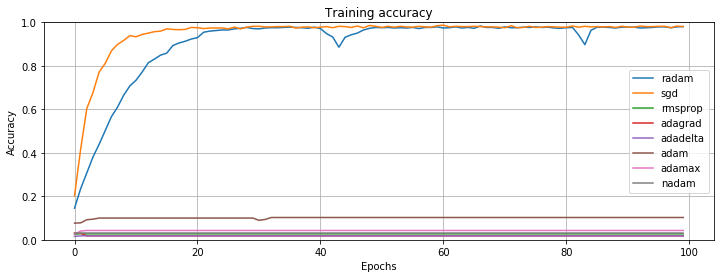

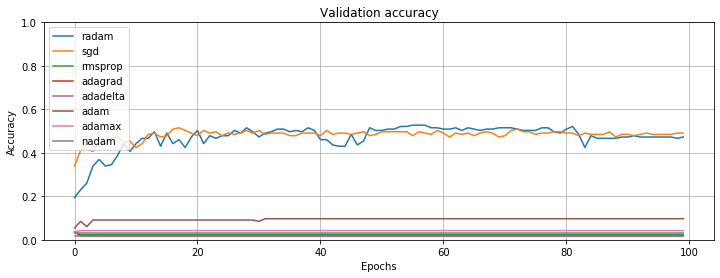

In [27]:
model='CNN_2D'
scores=['test score accuracy']
plot_training_accuracy(training_accuracy,optimizers,model)
plot_validation_accuracy(validation_accuracy,optimizers,model)
plot_test_scores(scores,y,model)

Confusion matrix

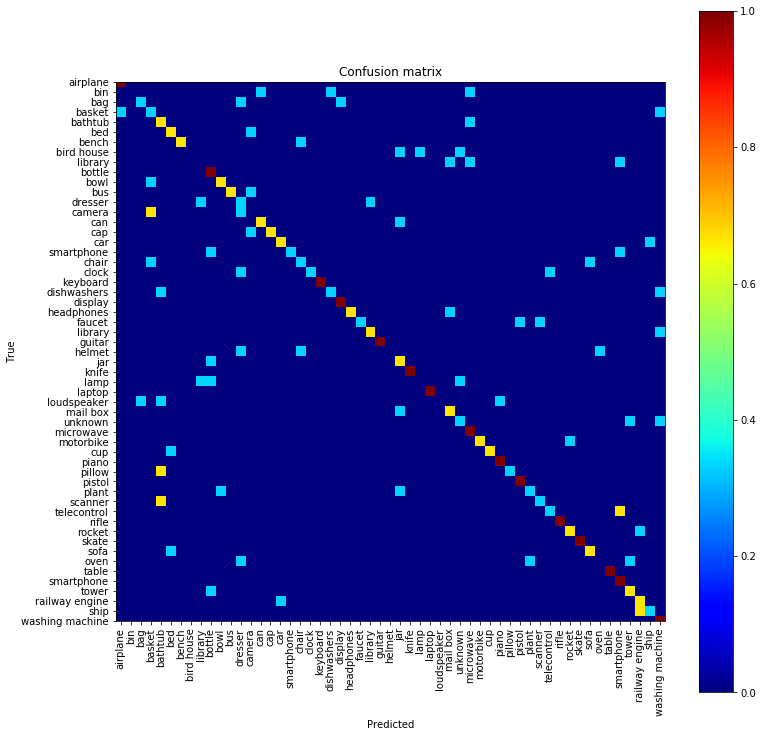

C:\Users\Fede\Anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



                 precision    recall  f1-score   support

       airplane       0.75      1.00      0.86         3
            bin       0.00      0.00      0.00         3
            bag       0.50      0.33      0.40         3
         basket       0.20      0.33      0.25         3
        bathtub       0.25      0.67      0.36         3
            bed       0.50      0.67      0.57         3
          bench       1.00      0.67      0.80         3
     bird house       0.00      0.00      0.00         3
        library       0.00      0.00      0.00         3
         bottle       0.43      1.00      0.60         3
           bowl       0.67      0.67      0.67         3
            bus       1.00      0.67      0.80         3
        dresser       0.17      0.33      0.22         3
         camera       0.00      0.00      0.00         3
            can       0.67      0.67      0.67         3
            cap       1.00      0.67      0.80         3
            car       0.67    

In [28]:
classes=np.load('classes.npy')
classifier=Classifier(128,0,best_hp,optimizer,'test')
classifier.load_weights('best_model_CNN_2Dsgd.h5')
predictions = classifier.predict(test_set)
new_test_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])
plot_confusion_matrix(new_test_labels,y_pred,classes,'CNN_2D')
print(classification_report(new_test_labels, y_pred, target_names=classes))

True class:  library
Predicted clas:  mail box


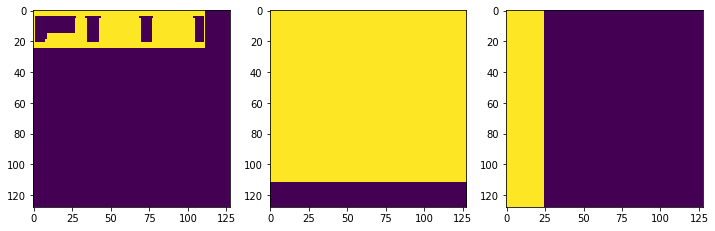

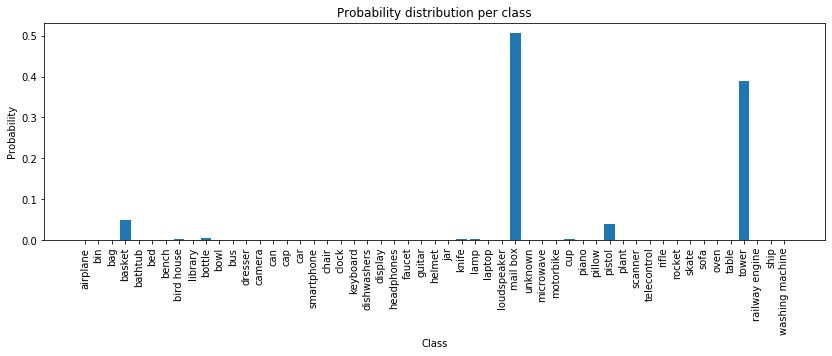

In [29]:
sample = np.random.randint(test_set.shape[0])
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].imshow(np.asarray(test_set[sample,0]))
ax[1].imshow(np.asarray(test_set[sample,1]))
ax[2].imshow(np.asarray(test_set[sample,2]))
print ("True class: ",classes[np.argmax(test_labels[sample])])
print ("Predicted clas: ",classes[np.argmax(classifier.predict(test_set[sample].reshape(1,3,128,128)))])
plot_output_NN(classes,classifier,test_set[sample].reshape(1,3,128,128))

Part C of the Project - Use of GAN to create 3D models from 2D images

In [30]:
training_autoencoder=np.load('training_autoencoder.npy')
labels_autoencoder = np.load('labels_autoencoder_16.npy')
training_autoencoder = np.asarray(training_autoencoder)
labels_autoencoder = np.asarray(labels_autoencoder)
train_set = training_autoencoder[:int(0.7*training_autoencoder.shape[0])]
valid_set = training_autoencoder[int(0.7*training_autoencoder.shape[0]):]
train_labels = labels_autoencoder[:int(0.7*training_autoencoder.shape[0])]
valid_labels = labels_autoencoder[int(0.7*training_autoencoder.shape[0]):]
del training_autoencoder
del labels_autoencoder
print (train_set.shape)
print (valid_set.shape)
print (train_labels.shape)
print (valid_labels.shape)

(936, 64, 64, 14)
(402, 64, 64, 14)
(936, 16, 16, 16)
(402, 16, 16, 16)


In [54]:
#Input image
K.clear_session()
input_img= Input(shape=(64,64,14))
concatenated_layers = []
encoded = Conv2D(64, kernel_size=2,activation='relu',padding='same')(input_img)
encoded = MaxPooling2D(pool_size=2)(encoded)
encoded = Conv2D(16, kernel_size=2,activation='relu',padding='same')(encoded)
encoded = MaxPooling2D(pool_size=2)(encoded)
encoded = Conv2D(32, kernel_size=2,activation='relu',padding='same')(encoded)
encoded = MaxPooling2D(pool_size=2)(encoded)
encoded = Conv2D(64, kernel_size=2,activation='relu',padding='same')(encoded)
encoded = Flatten()(encoded)
decoded = Reshape((16,16,16), input_shape=(4096,))(encoded)
#decoded = UpSampling3D((2,2,2))(decoded)
#decoded = UpSampling3D((2,2,2))(decoded)
#decoded = Conv3D(16,kernel_size=2,activation='relu',padding='same')(decoded)
#decoded = Conv3D(1,kernel_size=3,activation='relu',padding='same')(decoded)
#decoded = UpSampling3D((2,2,2))(decoded)
#decoded = Reshape((32,32,32,1))(decoded)
#decoded = Conv3D(32,kernel_size=2,activation='relu',padding='same')(decoded)
#decoded = Conv3D(1,kernel_size=3,activation='sigmoid',padding='same')(decoded)
#decoded = Reshape((32,32,32))(decoded)
#decoded = UpSampling3D((2,2,2))(decoded)

autoencoder=Model(input_img, decoded)
encoder = Model(input_img, encoded)

# compiling the autoencoder
autoencoder.compile(optimizer=RAdam(), loss='mean_squared_error', metrics=['accuracy'])
# Fitting the noise trained data to the autoencoder 
history=autoencoder.fit(train_set,train_labels,epochs=100,batch_size=2,verbose=0,
                       validation_data=(valid_set,valid_labels))

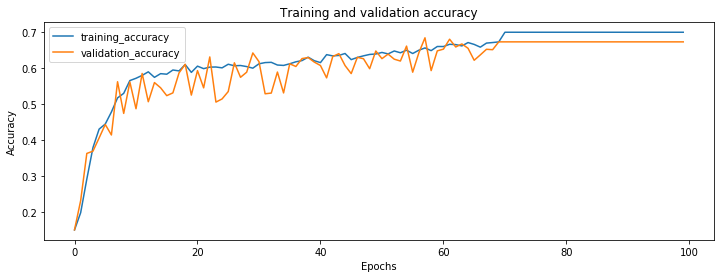

In [55]:
plt.figure(figsize=(12,4))
plt.plot(history.history['acc'],label='training_accuracy')
plt.plot(history.history['val_acc'],label='validation_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [47]:
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 14)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        3648      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4112      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
__________

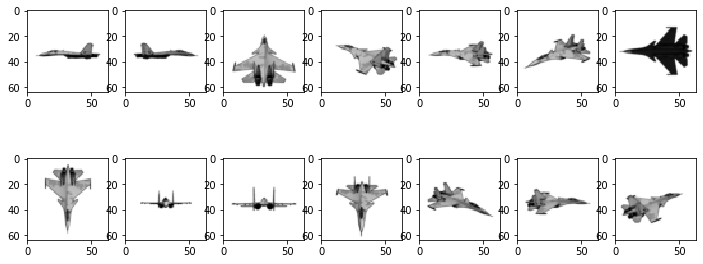

In [48]:
fig,ax=plt.subplots(2,7,figsize=(12,5))
for l in range(1):
    for i in range(14):
        j = int(i/7)
        k = (i%7)
        ax[j,k].imshow(train_set[30,:,:,i],cmap=plt.cm.binary_r)

In [49]:
volume = train_labels[30]
plot_model(volume)
print (volume.shape)

(16, 16, 16)


In [50]:
sample=np.random.randint(train_set.shape[0])
print (sample)
volume=autoencoder.predict(train_set[30].reshape(1,64,64,14))
volume=volume[0]
print (volume.shape)

233
(16, 16, 16)


In [51]:
plot_model(volume)